In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


%matplotlib inline

##### Helpers

In [18]:
def sqnorm(x):
    return np.dot(x,x)

## Sparse Reconstruction with $l_0$-penalty:

$$\min_{\alpha \in \mathbf{R}^P} ||x - D \alpha||_2^2 \quad s.t. ||\alpha||_0 \leq k$$

### Coordinate Descent Algorithms

#### Matching Pursuit

In [227]:
def matching_pursuit(D, x, k_max=10, eps=1e-10, max_itr=1000):
    itr     = 0    
    m, p    = D.shape
    alpha   = np.zeros(p)
    k = 0
    obj_values = []
    while k < k_max and itr < max_itr:
        d_prod = np.dot(D.T, x - np.dot(D,alpha))
        j = np.argmax(np.abs(d_prod))
        if alpha[j] == 0:
            k += 1
        
        alpha[j] += d_prod[j]
        itr += 1
        diff = sqnorm(x - np.dot(D,alpha))
        # print diff
        obj_values.append(diff)
    
    return (alpha, obj_values)


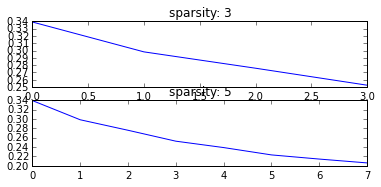

In [228]:
m = 160              # dimension of each atom
p = 100              # number of atoms
rand = np.random.rand
D = rand(m*p).reshape(m,p)    # dictionary
x = rand(m)
# normalise by column
D = D / la.norm(D,axis=0)
x = x / la.norm(x)

alpha, obj_values = matching_pursuit(D, x, k_max=3, max_itr=100)
s = "sparsity: {}".format(len(np.nonzero(alpha)[0]))
plt.subplot(3, 1, 1)
plt.title(s)
plt.plot(np.array(obj_values))

alpha, obj_values = matching_pursuit(D, x, k_max=5, max_itr=100)
s2 = "sparsity: {}".format(len(np.nonzero(alpha)[0]))
plt.subplot(3, 1, 2)
plt.title(s2)
plt.plot(np.array(obj_values))

#### Orthogonal Matching Pursuit (OMP)

In [229]:
def orthogonal_matching_pursuit(D, x, k_max=10, eps=1e-10, max_itr=1000):
    itr     = 0
    m, p    = D.shape
    # print "p: {}".format(p)
    k = 0
    alpha   = np.zeros(p)
    active_set = []
    obj_values = []
    while len(active_set) < k_max and itr < max_itr:
        min_j = 0
        min_beta = 0
        delta = sqnorm(x)
        for j in xrange(p):
            if j not in active_set:                
                gamma = active_set + [j]
                D_gamma = D[:,gamma]
                # Compute: (D_gamma.T * D_gamma)^-1 * D_gamma.T * x
                beta = np.dot(la.inv(np.dot(D_gamma.T,D_gamma)),np.dot(D_gamma.T,x))
                x_projected = np.dot(D_gamma, beta)
                curr_delta = sqnorm(x - x_projected)
                #print "j:{}, active_set:{}, delta:{}".format(j,active_set,curr_delta)
                if curr_delta <= delta:
                    delta = curr_delta
                    min_j = j
                    min_beta = beta
        
        # update active set and the solution alpha
        active_set += [min_j]
        alpha[active_set] = min_beta
        complement_set = [idx for idx in xrange(p) if idx not in active_set ]
        alpha[complement_set] = 0
        itr += 1
        # diff = sqnorm(x - np.dot(D,alpha)) # this should be the same as delta 
        # print diff 
        # obj_values.append(diff)
        obj_values.append(delta)
    
    return (alpha, obj_values)


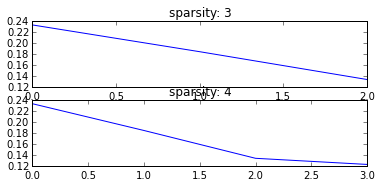

In [231]:
m = 10              # dimension of each atom
p = 5              # number of atoms
rand = np.random.rand
D = rand(m*p).reshape(m,p)    # dictionary
x = rand(m)
# normalise by column
D = D / np.linalg.norm(D,axis=0)
x = x / np.linalg.norm(x)

alpha, obj_values = orthogonal_matching_pursuit(D, x, k_max=3)
s = "sparsity: {}".format(len(np.nonzero(alpha)[0]))
plt.subplot(3, 1, 1)
plt.title(s)
plt.plot(np.array(obj_values))

alpha, obj_values = orthogonal_matching_pursuit(D, x, k_max=4)
s2 = "sparsity: {}".format(len(np.nonzero(alpha)[0]))
plt.subplot(3, 1, 2)
plt.title(s2)
plt.plot(np.array(obj_values))

Q. It still monotonically decreases like in MP. However, in MP, the rate of convergence also monotonically decreased (gave me a nice curve for decrease in obj function) but not here. I guess orthogonal projection isn't "greedy" in that sense? 

### Gradient Descent Techniques

Solves $$\min_{\alpha \in \mathbf{R}^P} ||x - D \alpha||_2^2 + \lambda ||\alpha||_0$$

### Iterative hard-thresholding

In [34]:
import heapq

def nth_largest(n, itr):
    return heapq.nlargest(n, itr)[-1]

def hard_thresholding(elt, threshold):
    return elt if np.abs(elt) >= threshold else 0

def iterative_hard_thresholding(D, x, k_max=None, lmbda=None, mu=0.01, alpha=None, T=100):
    '''
    Parameters:
        x     - input vector
        D     - dictionary
        k_max - target sparsity
        lmbda - sparsity penalty
        mu    - step size for each gradient descent
        alpha - initial alpha
        T     - # of iteration
    '''
    m, p    = D.shape
    if not lmbda:
        lmbda = 0.1
    tau = np.sqrt(2 * lmbda)
        
    if not alpha:
        alpha   = np.zeros(p)
    obj_values = []
    for i in xrange(T):
        # perform one step gradient
        alpha = alpha + mu * np.dot(D.T, x - np.dot(D,alpha))
        
        if k_max:
            # pick k largest elements
            tau = nth_largest(k_max, alpha)

            
#         print alpha
        
        alpha = map(hard_thresholding, alpha, [tau]*p)
            
        obj_values.append(sqnorm(x - np.dot(D,alpha)))
            
    return alpha, obj_values


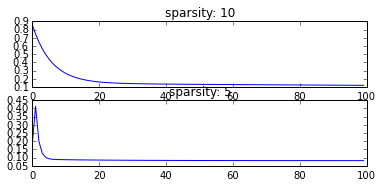

In [49]:
m = 10                     # dimension of each atom
p = 50                      # number of atoms
rand = np.random.rand
D = rand(m*p).reshape(m,p) # dictionary
x = rand(m)

# normalise by column
D = D / np.linalg.norm(D,axis=0)
x = x / np.linalg.norm(x)

alpha, obj_values = iterative_hard_thresholding(D, x, k_max=10)
s = "sparsity: {}".format(len(np.nonzero(alpha)[0]))
plt.subplot(3, 1, 1)
plt.title(s)
plt.plot(np.array(obj_values))

alpha, obj_values = iterative_hard_thresholding(D, x, lmbda=0.003, mu=0.1)
s2 = "sparsity: {}".format(len(np.nonzero(alpha)[0]))
plt.subplot(3, 1, 2)
plt.title(s2)
plt.plot(np.array(obj_values))

How to pick lambda and the stepsize mu?